# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
# Run the comment below only when using Google Colab
!pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

**get_sample_image**: GAN 모델 학습 후에 Generator가 이미지를 잘 만드는지 확인하기 위한 함수

**Line 5**: Generator의 input으로 사용될 noise를 배치 사이즈만큼 sampling 한다.

**Line 6**: Generator의 output을 이미지 형태로 reshape한다.

**Line 7**: gpu에 있는 데이터를 cpu로 가져오고 graph와 관계없이 데이터 자체에 대해서 numpy로 변환한다.

**Line 8**: 시각화를 위해 저장할 배열 선언

**Line 9-10**: 만들어낸 이미지 100장에 대해서 시각화하기 위해 (8)에서 선언한 배열에 반복적으로 부분 저장

![](assets/GAN.jpg)

In [8]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

**Discriminator**: GAN의 Discriminator model architecture 정의. Fully-connected layer 3개로 구성. 마지막은 확률로 나타내기 위해 sigmoid 사용

In [9]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

**Generator**: 일반적으로 Generator는 Discriminator보다 학습하기 어려우므로 더 깊게 FC layer 5개로 구성.

In [10]:
n_noise = 100

In [11]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

각각 모델을 메모리에 올리는 작업

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


**transforms** torchvision에서 제공하는 transform 함수들이 있는 패키지.

**ToTensor**는 numpy array를 torch tensor로 변환.

**Normalize**는 다음과 같이 계산함. input[channel] = (input[channel] - mean[channel]) / std[channel]

In [13]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 160198636.15it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25944676.34it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41021225.06it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21574777.77it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



GAN에서는 noise sample로부터 새로운 이미지를 만들어내는 작업이기 때문에 따로 test set을 불러올 필요가 없음.

In [14]:
batch_size = 64

In [15]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

**DataLoader**는 pytorch에서 학습 시에 데이터를 배치 사이즈만큼씩 효율적으로 불러오도록 돕는 클래스. 잘 사용할수록 GPU의 사용률이 올라간다.

**shuffle**: every epochs 마다 데이터의 순서를 랜덤하게 섞는다.

**drop_last**: 데이터의 개수가 배치 사이즈로 나눠떨어지지 않는 경우, 마지막 배치를 버린다. 주로 학습시에만 사용.

In [16]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

**GAN objective**

$$\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{data}~(x)}[log D(x)] + \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z)))]$$

**nn.BCELoss**: Binary Cross Entropy

$$-{[y\log(\hat{y}) + (1 - y)\log(1 - \hat{y})]}$$

**ADAM betas**: exponential decay rates for the moment estimates. (default: (0.9, 0.999))

$$\beta_1, \beta_2 \in [0,1)$$

In [17]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [18]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

Discriminator를 학습할 때는 **D(x)**는 1이 나오도록 **D(G(z))**에 대해서는 0이 나오도록,

Generator를 학습할 때는 **D(G(z))**에 대해 1이 나오도록 학습하기 위해 Discriminator의 label 준비

In [19]:
if not os.path.exists('samples'):
    os.makedirs('samples')

### Training Code



**line 2**: GAN에서는 MNIST의 class가 필요없으므로 image만 취함.

**line 4-6**: Real sample **x**에 대해 D를 forward하고 loss 계산

**line 8-10**: Fake sample **G(z)**에 대해 D를 forward하고 loss 계산

**line 11**: 위 2개의 loss를 합산

**line 13-15**: gradient 초기화 --> backward하면서 계산 --> parameter 업데이트

**line 17**: GAN에서 gradient를 계산하는 방법은 Discriminator에 의존하므로 D를 잘 학습시키기 위해 G보다 여러번 학습시키는 테크닉. W-GAN에서 사용

**line 19-25**: Generator를 위해 (8-10)과 반대로 loss를 계산하는 부분. non saturating loss **-log(D(G(z)))**를 사용하는 이유는 아래 언급함.

**line 21**: 이론적으로 **log(1-D(G(z)))**를 minimize하는 것이 맞으나, 학습 초기에 G가 이미지를 잘 만들지 못해 gradient가 작은 문제로 saturate 될 수 있으므로, 그 대안으로 제시된 것이 **log(D(G(z)))**를 maximize하는 것이다.

**line 30-34**: 1000 step마다 Generator가 학습이 잘 되고 있는지 샘플 이미지 만들어서 저장

In [34]:
D_losses = []
G_losses = []

for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

            # Save losses
            D_losses.append(D_loss.item())
            G_losses.append(G_loss.item())

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 100 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 55000, D Loss: 1.1903533935546875, G Loss: 1.1270148754119873
Epoch: 0/50, Step: 55500, D Loss: 1.2374999523162842, G Loss: 0.7652740478515625
Epoch: 1/50, Step: 56000, D Loss: 1.2191953659057617, G Loss: 1.112455129623413
Epoch: 2/50, Step: 56500, D Loss: 1.2680705785751343, G Loss: 0.8467628955841064
Epoch: 2/50, Step: 57000, D Loss: 1.2429497241973877, G Loss: 0.9959931373596191
Epoch: 3/50, Step: 57500, D Loss: 1.2287826538085938, G Loss: 0.8925116658210754
Epoch: 3/50, Step: 58000, D Loss: 1.1912304162979126, G Loss: 0.9896775484085083
Epoch: 4/50, Step: 58500, D Loss: 1.2547016143798828, G Loss: 0.9236281514167786
Epoch: 4/50, Step: 59000, D Loss: 1.29583740234375, G Loss: 1.1659092903137207
Epoch: 5/50, Step: 59500, D Loss: 1.1726479530334473, G Loss: 1.0314910411834717
Epoch: 5/50, Step: 60000, D Loss: 1.2311464548110962, G Loss: 1.1814980506896973
Epoch: 6/50, Step: 60500, D Loss: 1.1988821029663086, G Loss: 0.8177826404571533
Epoch: 6/50, Step: 61000, D Los

## Visualize Sample

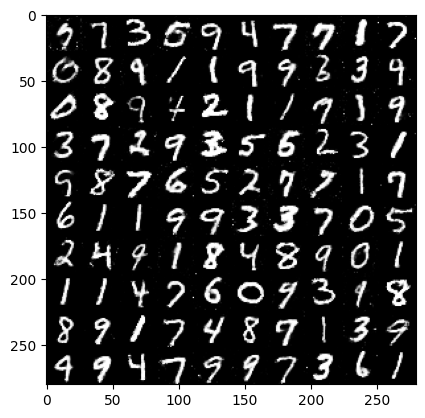

In [51]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

sample jpg > gif 만들기

In [57]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-3802li_i
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-3802li_i
  Resolved https://github.com/tensorflow/docs to commit 8246c1cba26bb07d9c02c165d83936c5b50825ca
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.12.6.69331-py3-none-any.whl size=181263 sha256=85bae6b7048a4787bc9f4d9dd80a77f88a4ce33ab0e3e9ab6e12cc13cfc94049
  Stored in directory: /tmp/pip-ephem-wheel-cache-4z9tgyhc/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [63]:
import os
import imageio
from IPython.display import display, Image

# Directory containing images
image_dir = 'samples/'

# List the images in the directory
images = [img for img in os.listdir(image_dir) if img.endswith(".jpg")]
images.sort()  # Sort the images to maintain the order

# Create a list to store image paths
image_paths = [os.path.join(image_dir, img) for img in images]

# Create video file path
video_path = 'samples/sample_video.mp4'

# Create video
with imageio.get_writer(video_path, fps=1) as writer:
    for image_path in image_paths:
        image = imageio.imread(image_path)
        writer.append_data(image)


<ipython-input-63-96983e5ea937>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [ ]:
from IPython.display import display, Video

# Display the video
display(Video(video_path, embed=True))
# https://colab.research.google.com/drive/17mN1tyERfQgGujRZTeQNq9HlxzLYmjSZ?usp=sharing

In [42]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')

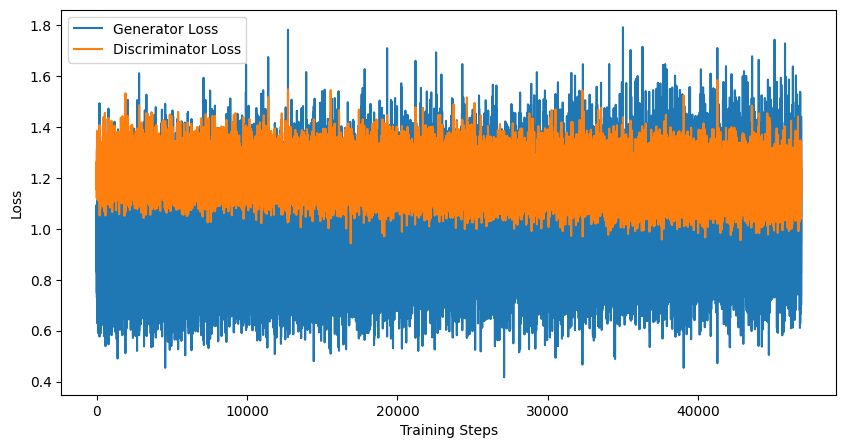

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()
